# Hamiltonian simulation with Gray code encoding - statevector simulator

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [2]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]

n_qubits=2
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)

{'IX': -7.813951636042159, 'ZX': 3.5273445861715977, 'XI': -3.913118960624632, 'XZ': 3.913118960624632, 'II': 14.3283547225, 'ZI': -8.4216452775, 'IZ': -1.4216452774999997, 'ZZ': -4.9216452775}


In [3]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


In [4]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=10
delta_time=0.01

initialization="zeros"
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

threshold=1e-2
backend = 'qasm_simulator'
qasm_energies,Ccoefs_qasm=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=None)



100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


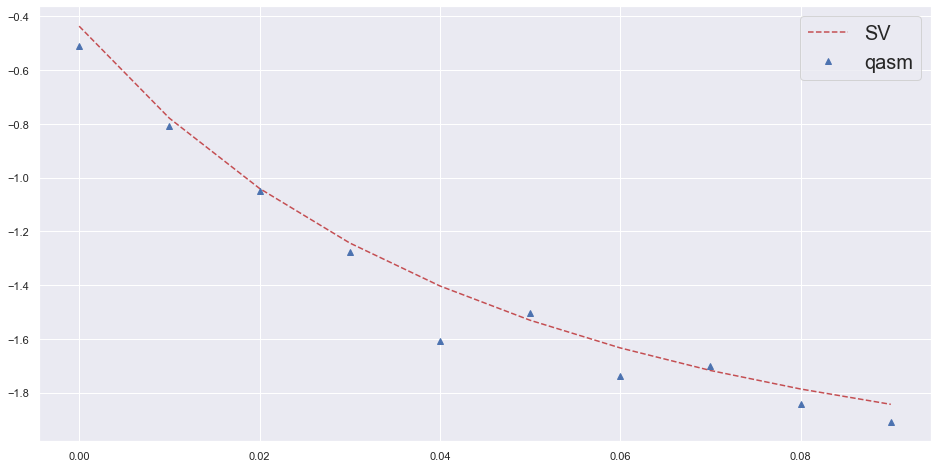

In [12]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="SV")
plt.plot(time,qasm_energies,'b^',label="qasm")
plt.legend(prop={'size': 20})

In [6]:
print(Ccoefs_sv)

[1.00436581 1.00778944 1.0104042  1.01243448 1.01403395 1.01531032
 1.0163404  1.01717986 1.01786962 1.01844022]


In [7]:
print(Ccoefs_qasm)

[1.00378783 1.00705574 1.01039165 1.01198037 1.01386246 1.01452111
 1.01638496 1.01545054 1.01865951 1.02070174]


In [20]:
## Construct overlap matrix
dim=int(num_iterations/2)
Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))
for i in range(0,dim):
    for j in range(0,dim):
        k=int((i+j)/2)
        Omatrix[i,j]=Ccoefs_sv[k]**2
print(Omatrix)
## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        k=int((i+j)/2)
        Hmatrix[i,j]=sv_energies[k]
print(Hmatrix)


[[1.00875068 1.00875068 1.01563956 1.01563956 1.02091665]
 [1.00875068 1.01563956 1.01563956 1.02091665 1.02091665]
 [1.01563956 1.01563956 1.02091665 1.02091665 1.02502358]
 [1.01563956 1.02091665 1.02091665 1.02502358 1.02502358]
 [1.02091665 1.02091665 1.02502358 1.02502358 1.02826485]]
[[-0.43658111 -0.43658111 -0.77894413 -0.77894413 -1.04042021]
 [-0.43658111 -0.77894413 -0.77894413 -1.04042021 -1.04042021]
 [-0.77894413 -0.77894413 -1.04042021 -1.04042021 -1.24344799]
 [-0.77894413 -1.04042021 -1.04042021 -1.24344799 -1.24344799]
 [-1.04042021 -1.04042021 -1.24344799 -1.24344799 -1.4033951 ]]
